In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('./..')
sys.path.append('./../..')
from pandarallel.utils.inliner import inline
from tqdm import tqdm
from collections import OrderedDict
try:
    from data_fetcher import data_fetcher
except:
    from .data_fetcher import data_fetcher
try:
    from model import model_6_v1 as Model
except:
    from .model import model_6_v1 as Model

from pathlib import Path
import multiprocessing
from pprint import pprint
import torch
import math
import yaml
import matplotlib.pyplot  as plt
from sklearn.metrics import auc

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Current device  >>  cuda


In [3]:
import model_data_fetcher

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)

Current device  >>  cuda


In [5]:
def visualize( model_obj, x1,x2 ):
   
    from sklearn.decomposition import TruncatedSVD
    try :
        %matplotlib inline
    except:
        pass
    import matplotlib.pyplot as plt
    
    x1 = model_obj.get_compressed_embedding(x1)
    x2 = model_obj.get_compressed_embedding(x2)
    
    svd = TruncatedSVD(n_components=2, n_iter=100, random_state=42)
    x = np.vstack([x1,x2])
    x3 = svd.fit_transform(x)

    plt.figure(figsize=[10,10])
    plt.scatter(x3[:len(x1),0], x3[:len(x1),1], c='g',alpha=0.95)
    plt.scatter(x3[len(x1):,0], x3[len(x1):,1], c='r',alpha=0.35)
    plt.show()
    
    svd = TruncatedSVD(n_components=3, n_iter=100, random_state=42)
    x = np.vstack([x1,x2])
    x3 = svd.fit_transform(x)
    fig = plt.figure(figsize=[14,14])
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter( x3[:len(x1),0], x3[:len(x1),1], x3[:len(x1),2], c ='g',alpha=0.95 , marker='^')
    ax.scatter( x3[len(x1):,0], x3[len(x1):,1], x3[len(x1):,2], c ='r',alpha=0.35 , marker='v')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()
    return

In [6]:
def create_config(
        data_set
):
    # Should return :
    # data_dict
    # meta_data_df [column, dimension]

    config_file = 'architecture_config.yaml'
    
    with open(config_file, 'r') as fh :
        config = yaml.safe_load(fh)
    config = config[data_set]
    latent_dim = config['ae_latent_dimension']

    data_dict, meta_data_df = data_fetcher.get_data(data_set,True)

    # discrete_columns : { column_name : num_categories }
    discrete_dims = OrderedDict ({k: v for k, v in zip(list(meta_data_df['column']), list(meta_data_df['dimension']))})
    num_discrete_columns = len(discrete_dims)
    count_discrete_dims = 0
    for val in discrete_dims.values():
        if val == 2:
            count_discrete_dims += 1
        else:
            count_discrete_dims += val
            
    real_dims = len(data_dict['train'].columns) - count_discrete_dims

    # ---------------
    # encoder_structure_config['ip_layers']
    # Format :
    # [ 'emb|onehot', num_categories, [ embedding dimension ]
    # ---------------
    encoder_structure_config = {
        'real_dims': real_dims,
        'discrete_dims': discrete_dims,
        'encoder_FCN_to_latent': config['encoder_FCN_to_latent'],
        'ae_latent_dimension' :  config['ae_latent_dimension'],
        'encoder_discrete_xform' : config['encoder_discrete_xform'],
        'encoder_real_xform' : config['encoder_real_xform']
    }

    # ======================================================
    # Set decoder structure
    # =========

    decoder_structure_config = {
        'real_dims': real_dims,
        'discrete_dims': discrete_dims,
        'decoder_FC_from_latent': config['decoder_FC_from_latent'],
        'decoder_discrete_xform' : config['decoder_discrete_xform'],
        'decoder_real_xform' : config['decoder_real_xform'],
        'ae_latent_dimension': config['ae_latent_dimension']
    }

    # ================
    # Format decoder_field_layers:
    # { idx : [[dim1,dim2], op_activation ]
    # ================
    loss_structure_config = {
        'discrete_dims' : discrete_dims,
        'real_loss_func': config['real_loss_func'],
        'real_dims':  real_dims
    }

    return encoder_structure_config, decoder_structure_config, loss_structure_config, latent_dim

encoder_structure_config, decoder_structure_config, loss_structure_config, latent_dim = create_config('nb15')
pprint(encoder_structure_config)
pprint(decoder_structure_config)

{'ae_latent_dimension': 8,
 'discrete_dims': OrderedDict([('proto', 133),
                               ('service', 11),
                               ('state', 9),
                               ('is_ftp_login', 3),
                               ('is_sm_ips_ports', 2)]),
 'encoder_FCN_to_latent': {'activation': 'tanh', 'dims': [48, 16]},
 'encoder_discrete_xform': {'proto': {'activation': 'none', 'dims': [8]}},
 'encoder_real_xform': {'activation': 'tanh', 'dims': [16]},
 'real_dims': 37}
{'ae_latent_dimension': 8,
 'decoder_FC_from_latent': {'activation': 'tanh', 'dims': [16, 48]},
 'decoder_discrete_xform': {'flag': {'activation': 'tanh', 'dims': None},
                            'is_guest_login': {'activation': 'tanh',
                                               'dims': None},
                            'land': {'activation': 'tanh', 'dims': None},
                            'logged_in': {'activation': 'tanh', 'dims': None},
                            'protocol_type': {'a

In [7]:
loss_structure_config

{'discrete_dims': OrderedDict([('proto', 133),
              ('service', 11),
              ('state', 9),
              ('is_ftp_login', 3),
              ('is_sm_ips_ports', 2)]),
 'real_loss_func': 'smooth_l1',
 'real_dims': 37}

In [14]:
# ======================================= #
num_anomaly_sets = 5
num_anomaly_sets = 5
anomaly_ratio = 0.1
data_dict, _ = data_fetcher.get_data('nb15', one_hot=True, )
pos, neg_x, data_dict = model_data_fetcher.fetch_model_data('nb15',num_anom_sets=num_anomaly_sets,anomaly_ratio=anomaly_ratio)

100%|██████████| 56000/56000 [04:19<00:00, 215.52it/s]


Size {:.3f} 63.09928798675537  MB 
Size {:.3f} 673.7407913208008  MB 
>  560000 80000


In [9]:
pos.shape

(39200, 194)

In [10]:
try:
    from model import model_6_v1_container as Model
except:
    from .model import model_6_v1_container as Model
    
ae_model =  Model(
    DEVICE,
    latent_dim,
    encoder_structure_config,
    decoder_structure_config,
    loss_structure_config,
    batch_size=256,
    learning_rate=0.0005,
    max_gamma=10,
    ae_dropout=0.2,
    fc_dropout=0.1,
    burn_in_epochs=10,
    phase_2_epochs=10,
    phase_3_epochs=10
 
)

print(ae_model.network_module)

split schema  [133, 11, 9, 3, 1, 37]
Loss structure config {'discrete_dims': OrderedDict([('proto', 133), ('service', 11), ('state', 9), ('is_ftp_login', 3), ('is_sm_ips_ports', 2)]), 'real_loss_func': 'smooth_l1', 'real_dims': 37}
 Loss module split schema  [133, 11, 9, 3, 1, 37]
Normal(loc: torch.Size([8]), scale: torch.Size([8]))
model_6_v1(
  (ae_module): AE(
    (encoder): AE_encoder(
      (input_x_form_layers): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=133, out_features=8, bias=True)
          (1): Identity()
        )
        (1): Identity()
        (2): Identity()
        (3): Identity()
        (4): Identity()
        (5): Sequential(
          (0): Linear(in_features=37, out_features=16, bias=True)
          (1): Tanh()
        )
      )
      (FC_z): Sequential(
        (0): Linear(in_features=48, out_features=48, bias=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Tanh()
        (3): Linear(in_features=48, out_features=16, bias=T

In [11]:
losses = ae_model.train_model(
    pos, 
    neg_x
)

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch 1 Batch 0 Loss 155.2260 || AE 155.2260 1.4044 
 Epoch 1 Batch 100 Loss 129.8598 || AE 129.8598 1.4750 


  3%|▎         | 1/30 [00:08<04:13,  8.74s/it]

Epoch loss :: 137.2532
 Epoch 2 Batch 0 Loss 115.6367 || AE 115.6367 1.4791 
 Epoch 2 Batch 100 Loss 109.9060 || AE 109.9060 1.4872 


  7%|▋         | 2/30 [00:16<03:59,  8.55s/it]

Epoch loss :: 110.7248
 Epoch 3 Batch 0 Loss 109.4935 || AE 109.4935 1.4936 
 Epoch 3 Batch 100 Loss 109.1838 || AE 109.1838 1.4859 


 10%|█         | 3/30 [00:24<03:43,  8.30s/it]

Epoch loss :: 109.25873
 Epoch 4 Batch 0 Loss 109.0735 || AE 109.0735 1.4886 
 Epoch 4 Batch 100 Loss 109.1433 || AE 109.1433 1.4885 


 13%|█▎        | 4/30 [00:32<03:29,  8.05s/it]

Epoch loss :: 109.07678
 Epoch 5 Batch 0 Loss 109.0338 || AE 109.0338 1.4859 
 Epoch 5 Batch 100 Loss 108.9979 || AE 108.9979 1.4895 


 17%|█▋        | 5/30 [00:39<03:15,  7.80s/it]

Epoch loss :: 109.00374
 Epoch 6 Batch 0 Loss 109.0179 || AE 109.0179 1.4847 
 Epoch 6 Batch 100 Loss 109.0022 || AE 109.0022 1.4872 


 20%|██        | 6/30 [00:46<03:05,  7.73s/it]

Epoch loss :: 108.96146
 Epoch 7 Batch 0 Loss 108.9456 || AE 108.9456 1.4863 
 Epoch 7 Batch 100 Loss 109.0136 || AE 109.0136 1.4818 


 23%|██▎       | 7/30 [00:54<02:56,  7.68s/it]

Epoch loss :: 108.93978
 Epoch 8 Batch 0 Loss 109.0650 || AE 109.0650 1.4875 
 Epoch 8 Batch 100 Loss 108.8242 || AE 108.8242 1.4842 


 27%|██▋       | 8/30 [01:01<02:48,  7.64s/it]

Epoch loss :: 108.92295
 Epoch 9 Batch 0 Loss 108.8207 || AE 108.8207 1.4848 
 Epoch 9 Batch 100 Loss 108.8856 || AE 108.8856 1.4858 


 30%|███       | 9/30 [01:09<02:41,  7.69s/it]

Epoch loss :: 108.910805
 Epoch 10 Batch 0 Loss 1.4907 || AE 108.7885 1.4907 
 Epoch 10 Batch 100 Loss 1.4080 || AE 108.9319 1.4080 


 33%|███▎      | 10/30 [01:18<02:42,  8.12s/it]

Epoch loss :: 1.4275558
 Epoch 11 Batch 0 Loss 47.0236 || AE 108.8212 6.9905 
 Epoch 11 Batch 100 Loss 45.3787 || AE 108.8508 5.3347 


 37%|███▋      | 11/30 [01:27<02:37,  8.28s/it]

Epoch loss :: 42.936157
 Epoch 12 Batch 0 Loss 19.5341 || AE 108.9079 4.7950 
 Epoch 12 Batch 100 Loss 17.9420 || AE 108.9321 3.1996 


 40%|████      | 12/30 [01:36<02:31,  8.42s/it]

Epoch loss :: 16.56308
 Epoch 13 Batch 0 Loss 8.1824 || AE 108.9030 2.7605 
 Epoch 13 Batch 100 Loss 7.5998 || AE 108.8573 2.1801 


 43%|████▎     | 13/30 [01:44<02:21,  8.35s/it]

Epoch loss :: 6.580996
 Epoch 14 Batch 0 Loss 3.9473 || AE 108.8652 1.9534 
 Epoch 14 Batch 100 Loss 3.5752 || AE 108.9968 1.5788 


 47%|████▋     | 14/30 [01:53<02:17,  8.58s/it]

Epoch loss :: 2.8309116
 Epoch 15 Batch 0 Loss 2.1504 || AE 108.8562 1.4169 
 Epoch 15 Batch 100 Loss 1.9396 || AE 108.9157 1.2057 


 50%|█████     | 15/30 [02:02<02:12,  8.81s/it]

Epoch loss :: 1.3624166
 Epoch 16 Batch 0 Loss 1.3576 || AE 108.8448 1.0878 
 Epoch 16 Batch 100 Loss 1.2038 || AE 108.9023 0.9338 


 53%|█████▎    | 16/30 [02:12<02:04,  8.92s/it]

Epoch loss :: 0.7655734
 Epoch 17 Batch 0 Loss 0.9852 || AE 108.9096 0.8859 
 Epoch 17 Batch 100 Loss 0.8892 || AE 108.8273 0.7899 


 57%|█████▋    | 17/30 [02:20<01:54,  8.84s/it]

Epoch loss :: 0.508717
 Epoch 18 Batch 0 Loss 0.8142 || AE 108.8885 0.7776 
 Epoch 18 Batch 100 Loss 0.6977 || AE 108.8285 0.6612 


 60%|██████    | 18/30 [02:30<01:48,  9.07s/it]

Epoch loss :: 0.38745028
 Epoch 19 Batch 0 Loss 0.6436 || AE 108.9435 0.6301 
 Epoch 19 Batch 100 Loss 0.6007 || AE 108.8671 0.5873 


 63%|██████▎   | 19/30 [02:39<01:40,  9.10s/it]

Epoch loss :: 0.3163743
 Epoch 20 Batch 0 Loss 0.6090 || AE 108.9321 0.6090 
 Epoch 20 Batch 100 Loss 0.4703 || AE 108.9807 0.4703 


 67%|██████▋   | 20/30 [02:47<01:28,  8.88s/it]

Epoch loss :: 0.48756507
 Epoch 21 Batch 0 Loss 0.4065 || AE 108.9238 0.4065 
 Epoch 21 Batch 100 Loss 0.3535 || AE 108.7968 0.3535 


 70%|███████   | 21/30 [02:56<01:18,  8.76s/it]

Epoch loss :: 0.3771469
 Epoch 22 Batch 0 Loss 0.3435 || AE 108.8094 0.3435 
 Epoch 22 Batch 100 Loss 0.3105 || AE 108.8958 0.3105 


 73%|███████▎  | 22/30 [03:06<01:13,  9.16s/it]

Epoch loss :: 0.30522132
 Epoch 23 Batch 0 Loss 0.2575 || AE 108.9074 0.2575 
 Epoch 23 Batch 100 Loss 0.2469 || AE 108.8567 0.2469 


 77%|███████▋  | 23/30 [03:16<01:06,  9.55s/it]

Epoch loss :: 0.25260243
 Epoch 24 Batch 0 Loss 0.2229 || AE 108.8977 0.2229 
 Epoch 24 Batch 100 Loss 0.1957 || AE 108.8945 0.1957 


 80%|████████  | 24/30 [03:25<00:56,  9.40s/it]

Epoch loss :: 0.21473485
 Epoch 25 Batch 0 Loss 0.1983 || AE 108.9000 0.1983 
 Epoch 25 Batch 100 Loss 0.1759 || AE 108.8906 0.1759 


 83%|████████▎ | 25/30 [03:34<00:45,  9.16s/it]

Epoch loss :: 0.18370911
 Epoch 26 Batch 0 Loss 0.1625 || AE 109.0209 0.1625 
 Epoch 26 Batch 100 Loss 0.1572 || AE 108.9409 0.1572 


 87%|████████▋ | 26/30 [03:44<00:37,  9.45s/it]

Epoch loss :: 0.16140398
 Epoch 27 Batch 0 Loss 0.1370 || AE 108.9079 0.1370 
 Epoch 27 Batch 100 Loss 0.1327 || AE 108.7929 0.1327 


 90%|█████████ | 27/30 [03:54<00:28,  9.49s/it]

Epoch loss :: 0.14259207
 Epoch 28 Batch 0 Loss 0.1315 || AE 108.8872 0.1315 
 Epoch 28 Batch 100 Loss 0.1243 || AE 108.8764 0.1243 


 93%|█████████▎| 28/30 [04:04<00:19,  9.70s/it]

Epoch loss :: 0.1270533
 Epoch 29 Batch 0 Loss 0.1180 || AE 108.9013 0.1180 
 Epoch 29 Batch 100 Loss 0.1034 || AE 108.9179 0.1034 


 97%|█████████▋| 29/30 [04:13<00:09,  9.45s/it]

Epoch loss :: 0.115046784
 Epoch 30 Batch 0 Loss 0.1024 || AE 108.9067 0.1024 
 Epoch 30 Batch 100 Loss 0.0973 || AE 108.7745 0.0973 


100%|██████████| 30/30 [04:23<00:00,  8.78s/it]

Epoch loss :: 0.103476755


In [12]:
def test_eval():
    global data_dict
    global ae_model
    global num_anomaly_sets
    
    test_norm_X =  data_dict['test']


    auc_list = []
    ae_model.mode = 'test'
    def _normalize_(val, _min,_max):
        return (val -_min)/(_max - _min)

    for idx in range(1, num_anomaly_sets+1):
        key = 'anom_'+str(idx)
        test_anom_df = data_dict[key]
        test_anom_X = test_anom_df.values
        x1 = test_norm_X
        x2 = test_anom_X


        x1_scores = ae_model.get_score(x1)
        x2_scores = ae_model.get_score(x2)

        res_data = []
        labels = [ 1 for _ in range(x1.shape[0])] +  [0 for _ in range(x2.shape[0])] 
        _scores = np.concatenate([x1_scores, x2_scores],axis=0)

        for i,j in zip(_scores, labels):
            res_data.append((i[0],j))

        res_df = pd.DataFrame(res_data, columns=['score','label'] )
        res_df = res_df.sort_values(by=['score'],ascending= True)


        _max = max(res_df['score'])
        _min = min(res_df['score'])

        res_df['score'] = res_df['score'].parallel_apply(
            _normalize_,
            args=(_min,_max, )
        )
        _max = max(res_df['score'])
        _min = min(res_df['score'])


        step = (_max - _min)/ 100

        # Vary the threshold
        thresh = _min + step
        thresh = round(thresh,3)
        num_anomalies = x2.shape[0]
        print('Num anomalies',num_anomalies )
        P = []
        R = [0]

        while thresh <= _max+step:

            sel = res_df.loc[res_df['score'] <= thresh]
            if len(sel) == 0 :
                thresh += step
                continue

            correct = sel.loc[sel['label'] == 0 ]

            prec = len(correct)/ len(sel)
            rec = len(correct)/num_anomalies

    #         print(thresh, prec, rec, '|| ', len(sel) ,'||' ,len(correct))
            P.append(prec)
            R.append(rec)
            thresh += step

        P = [P[0]] + P
        pr_auc = auc( R, P)
        pr_auc = auc( R, P)

        plt.figure(figsize=[8,6])
        plt.plot(R,P)
        plt.title('Precision Recall Curve  || auPR :' + "{:0.4f}".format(pr_auc), fontsize=15 )
        plt.xlabel('Recall',fontsize=15)
        plt.ylabel('Precision',fontsize=15)
        plt.show()

        print("AUC : {:0.4f} ".format(pr_auc))
        auc_list.append(pr_auc)



    print(' Mean AUC ', np.mean(auc_list))
    print(' AUC std ', np.std(auc_list)) 
    return auc_list

Num anomalies 1680


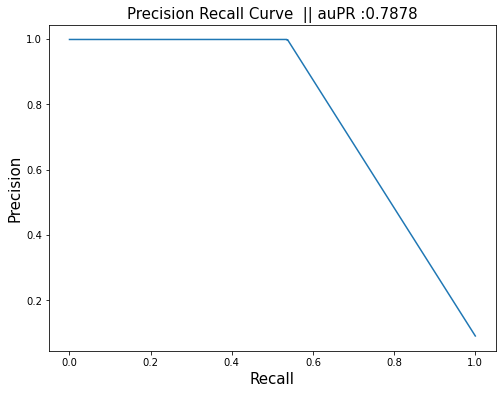

AUC : 0.7878 
Num anomalies 1680


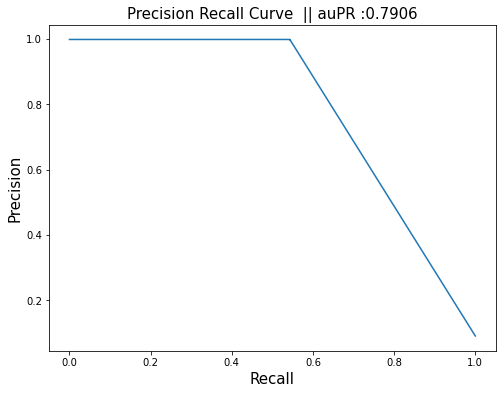

AUC : 0.7906 
Num anomalies 1680


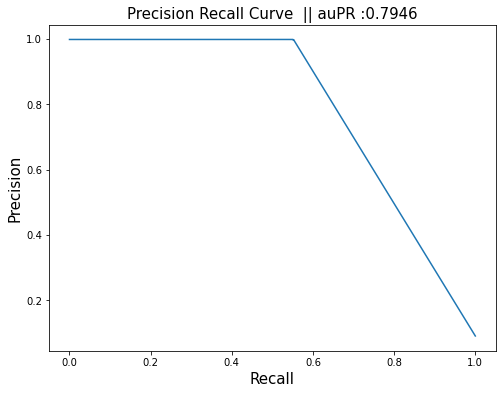

AUC : 0.7946 
Num anomalies 1680


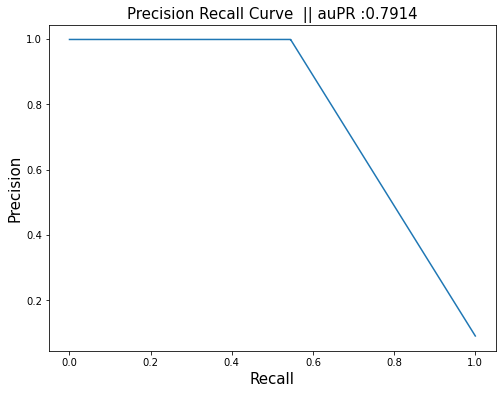

AUC : 0.7914 
Num anomalies 1680


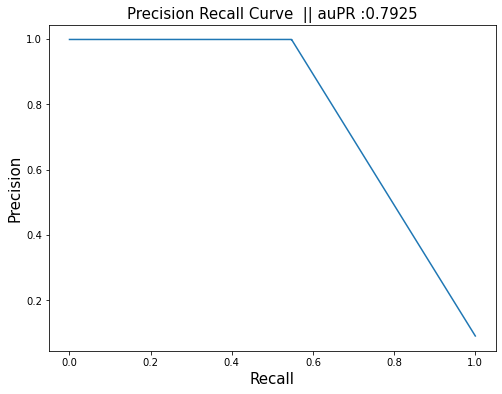

AUC : 0.7925 
 Mean AUC  0.7913723908986721
 AUC std  0.002245737982643631


[0.7878189093268414,
 0.7905546548660305,
 0.7946470960802978,
 0.7913747954087484,
 0.7924664988114419]

In [13]:
test_eval()

Num anomalies 3360


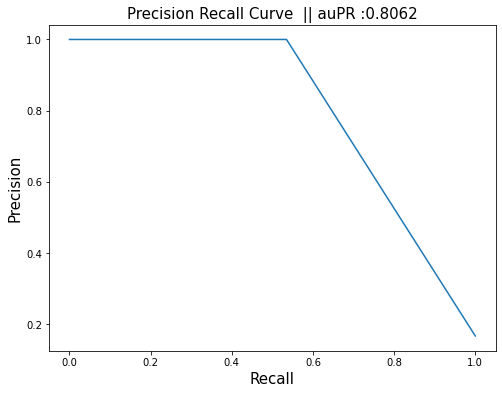

AUC : 0.8062 
Num anomalies 3360


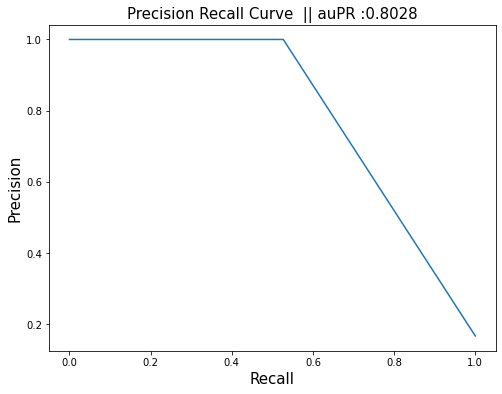

AUC : 0.8028 
Num anomalies 3360


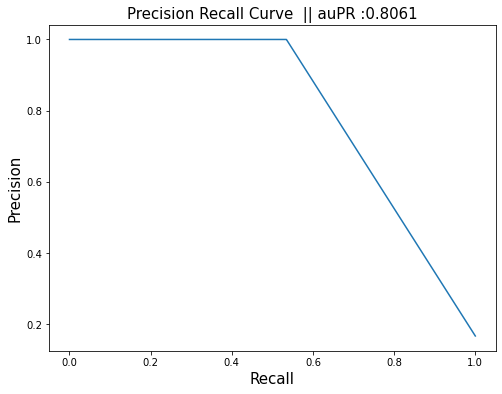

AUC : 0.8061 
Num anomalies 3360


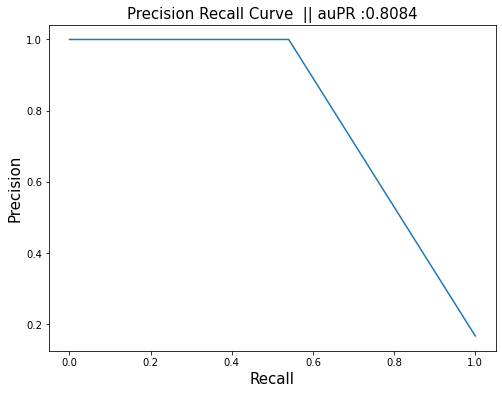

AUC : 0.8084 
Num anomalies 3360


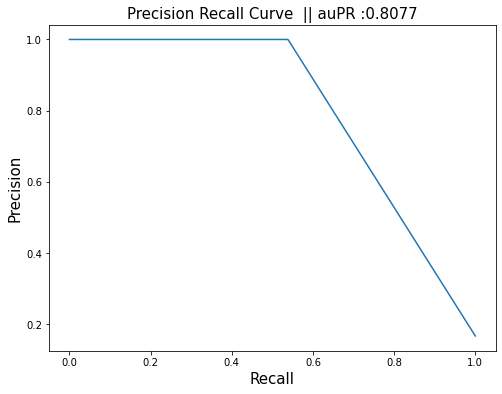

AUC : 0.8077 
 Mean AUC  0.8062251984126985
 AUC std  0.001918880072806037


[0.8061755952380952,
 0.8028273809523809,
 0.8060515873015873,
 0.8084077380952381,
 0.8076636904761905]

In [19]:
test_eval()

# =================================================================================

In [14]:
def viz_loss(losses):
    import matplotlib.pyplot as plt
    plt.figure(figsize=[8,6])
    plt.plot(list(range(len(losses[:]))),losses[:])
    plt.show()
    return

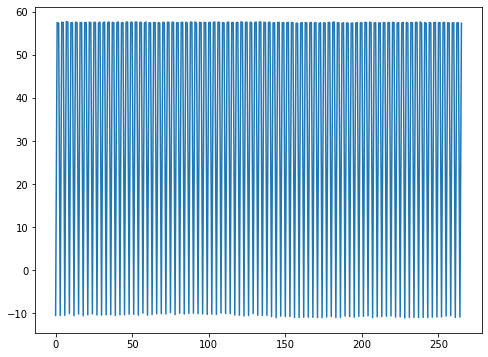

In [251]:
viz_loss(losses)

In [17]:

data_dict, _ = data_fetcher.get_data('nb15',True,anomaly_ratio=0.1)
train_df = data_dict['train']
train_X = train_df.values

test_norm_df = data_dict['test']
test_norm_X = test_norm_df.values

Size:  train_df 39200 , test_df 16800, anomaly data 5009, Req anomalies 1680


In [35]:
test_anom_df = data_dict['anom_3']
test_anom_X = test_anom_df.values
x1 = test_norm_X
x2 = test_anom_X

In [19]:
# pos,neg = model_data_fetcher.fetch_model_data('kddcup')

In [20]:
train_norm_df = data_dict['train']
x0 = train_norm_df.values

In [21]:
neg.shape

(39200, 10, 195)

In [22]:
neg1 = np.reshape(neg,[ neg.shape[0]* neg.shape[1] , neg.shape[2]])
np.random.shuffle(neg1)
neg1.shape

(392000, 195)

In [23]:
x3 = neg1[:10000]

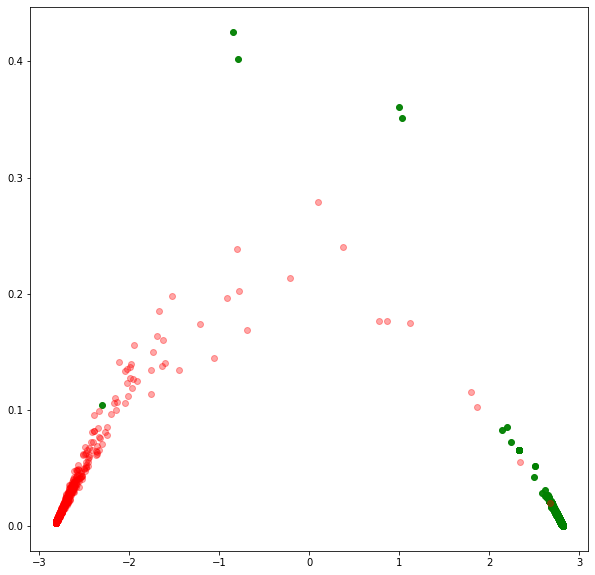

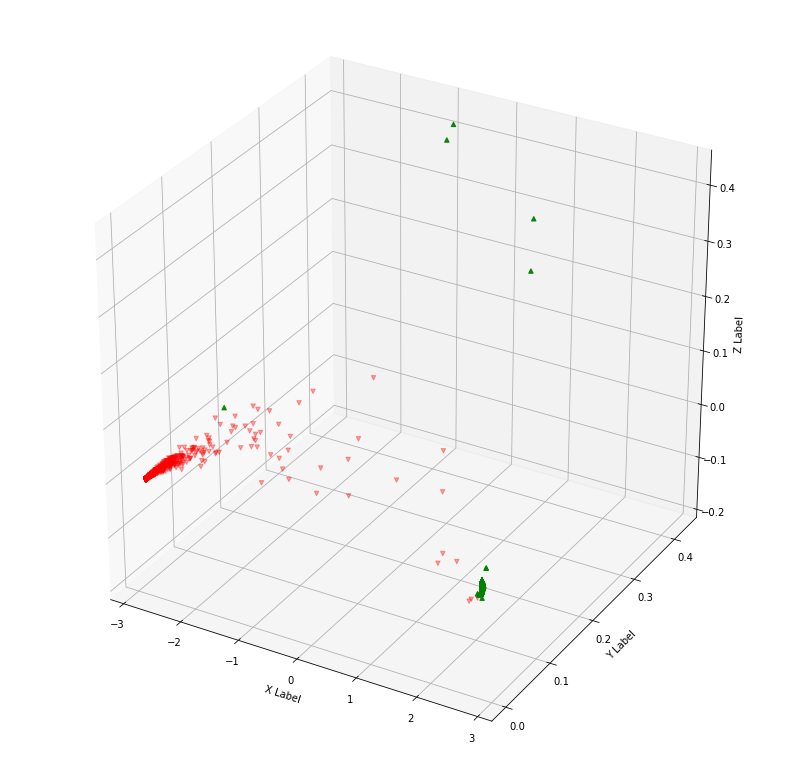

In [51]:
visualize( ae_model, x0, x3 )

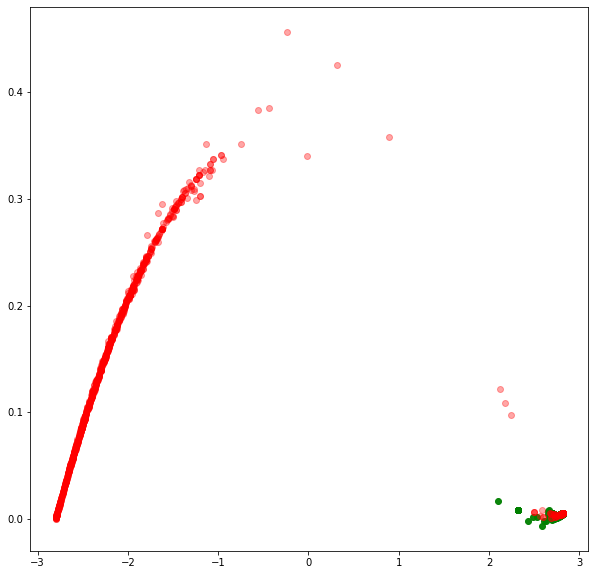

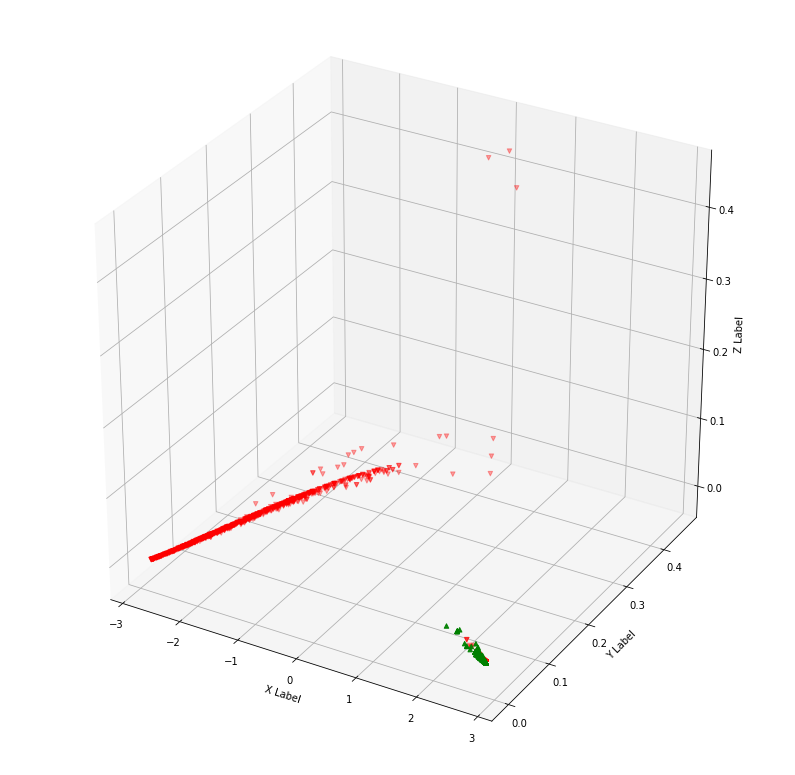

In [52]:
visualize( ae_model, x1, x2 )

In [26]:
x3_scores = ae_model.get_score(x3)
np.min(x3_scores), np.median(x3_scores), np.max(x3_scores)

(0.024375487, 0.024375891, 0.9933797)

In [27]:
x2_scores = ae_model.get_score(x2)

np.min(x2_scores), np.median(x2_scores), np.max(x2_scores)

(0.024385378, 0.032292437, 0.9934035)

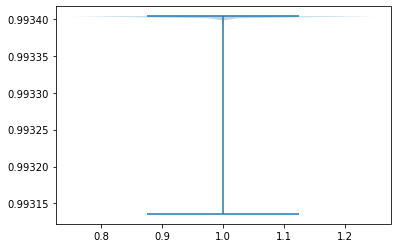

In [53]:
plt.violinplot(np.array(x1_scores))
plt.show()

In [29]:

x1_scores = ae_model.get_score(x1)
np.min(x1_scores), np.median(x1_scores), np.max(x1_scores)

(0.9931358, 0.99340314, 0.9934035)

In [36]:
ae_model.mode = 'test'

x1_scores = ae_model.get_score(x1)
x2_scores = ae_model.get_score(x2)

In [37]:
x1 = test_norm_X
x2 = test_anom_X

In [38]:
res_data = []
labels = [ 1 for _ in range(x1.shape[0])] +  [0 for _ in range(x2.shape[0])] 
_scores = np.concatenate([x1_scores, x2_scores],axis=0)

for i,j in zip(_scores, labels):
    res_data.append((i[0],j))
    
res_df = pd.DataFrame(res_data, columns=['score','label'] )
res_df = res_df.sort_values(by=['score'],ascending= True)




res_df['score'] = res_df['score'].parallel_apply(
    _normalize_,
    args=(_min,_max, )
)
res_df

In [41]:
max(res_df['score']),min(res_df['score'])

(1.0, 0.0)

In [45]:
_max = max(res_df['score'])
_min = min(res_df['score'])
step = (_max - _min)/ 100

# Vary the threshold
thresh = _min + step
num_anomalies = x2.shape[0]
print('Num anomalies',num_anomalies )
P = []
R = [0]

while thresh <= _max + step :
    
    sel = res_df.loc[res_df['score'] <= thresh]
    if len(sel) == 0 :
        thresh += step
        continue

    correct = sel.loc[sel['label'] == 0 ]
    
    prec = len(correct)/ len(sel)
    rec = len(correct)/num_anomalies
    
    print(thresh, prec, rec, '|| ', len(sel) ,'||' ,len(correct))
    P.append(prec)
    R.append(rec)
    thresh += step
    
P = [P[0]] + P

Num anomalies 1680
0.01 1.0 0.5101190476190476 ||  857 || 857
0.02 1.0 0.5345238095238095 ||  898 || 898
0.03 1.0 0.5446428571428571 ||  915 || 915
0.04 1.0 0.549404761904762 ||  923 || 923
0.05 1.0 0.5505952380952381 ||  925 || 925
0.060000000000000005 1.0 0.5511904761904762 ||  926 || 926
0.07 1.0 0.5511904761904762 ||  926 || 926
0.08 1.0 0.5511904761904762 ||  926 || 926
0.09 1.0 0.5511904761904762 ||  926 || 926
0.09999999999999999 1.0 0.5517857142857143 ||  927 || 927
0.10999999999999999 1.0 0.5517857142857143 ||  927 || 927
0.11999999999999998 1.0 0.5517857142857143 ||  927 || 927
0.12999999999999998 1.0 0.5517857142857143 ||  927 || 927
0.13999999999999999 1.0 0.5517857142857143 ||  927 || 927
0.15 1.0 0.5517857142857143 ||  927 || 927
0.16 1.0 0.5517857142857143 ||  927 || 927
0.17 1.0 0.5517857142857143 ||  927 || 927
0.18000000000000002 1.0 0.5517857142857143 ||  927 || 927
0.19000000000000003 1.0 0.5517857142857143 ||  927 || 927
0.20000000000000004 1.0 0.5523809523809524 |

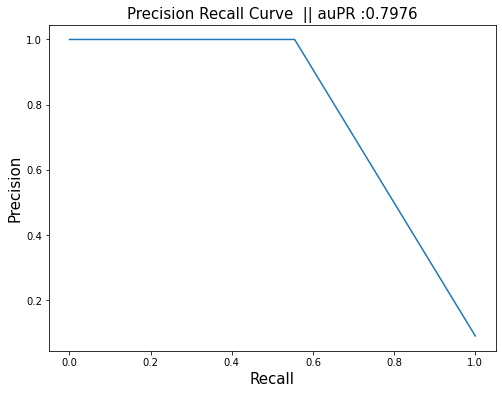

AUC : 0.7976 


In [46]:

from sklearn.metrics import auc
pr_auc = auc( R, P)

plt.figure(figsize=[8,6])
plt.plot(R,P)
plt.title('Precision Recall Curve  || auPR :' + "{:0.4f}".format(pr_auc), fontsize=15 )
plt.xlabel('Recall',fontsize=15)
plt.ylabel('Precision',fontsize=15)
plt.show()


print("AUC : {:0.4f} ".format(pr_auc))

In [337]:
a = torch.FloatTensor(np.random.random([512,1,4]))
a.shape

Current device  >>  cuda


torch.Size([512, 1, 4])

In [341]:
a.squeeze(1).squeeze(1).shape

torch.Size([512, 4])

In [3]:
# Load list of points for cluster analysis.
sample = read_sample(FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS)

In [35]:
from sklearn.datasets.samples_generator import make_blobs
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [82]:
centers = [(-5, -5, -6), (5, 5,0),(.25,1.25,2)]
cluster_std = [0.25,1.25,1.75]

X, y = make_blobs(n_samples=100, cluster_std=cluster_std, centers=centers, n_features=3, random_state=1)

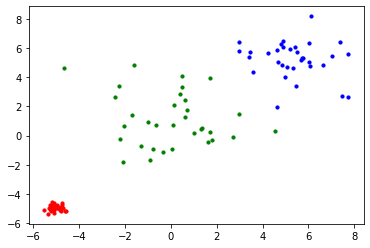

In [83]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red",  s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10, label="Cluster2")
plt.scatter(X[y == 2, 0], X[y == 2, 1], color="green",  s=10, label="Cluster1")


In [100]:
# Prepare initial centers using K-Means++ method.

def x_means(
    X,
    num_init_clusters = 8,
    visualize = True
):
    from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
    from pyclustering.cluster.xmeans import xmeans
    from pyclustering.cluster import cluster_visualizer
    from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
    from pyclustering.cluster import cluster_visualizer_multidim
    
    X = list(X)
    
    initial_centers = kmeans_plusplus_initializer(
        X, 
        amount_initial_centers
       
    ).initialize()

    start_centers = kmeans_plusplus_initializer(X, num_init_clusters).initialize()
   
    xmeans_instance = xmeans(X, start_centers, 20, ccore=True,  criterion = 0)
        

    # Run cluster analysis and obtain results.
    xmeans_instance.process()
    clusters = xmeans_instance.get_clusters()
    centers = xmeans_instance.get_centers()
    print('Number of cluster centers calculated :', len(centers))

    if visualize :
        visualizer = cluster_visualizer_multidim()
        visualizer.append_clusters(clusters, X)
        visualizer.show()
    return centers,clusters

Number of cluster centers calculated : 4


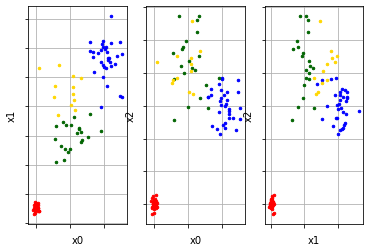

In [101]:

x_means(X,4)

In [31]:
# Prepare initial centers using K-Means++ method.


[array([5.35054598, 3.68771659])]


In [32]:
# Run cluster analysis and obtain results.
xmeans_instance_1.process()
clusters = xmeans_instance_1.get_clusters()
final_centers = xmeans_instance_1.get_centers()

In [33]:
final_centers

[[-4.957007090913727, -5.0115476154679115],
 [1.103508013001677, -1.0740079912115943],
 [1.0081270544323917, 2.3410526260307187],
 [4.899507476842758, 4.9839302284736595]]

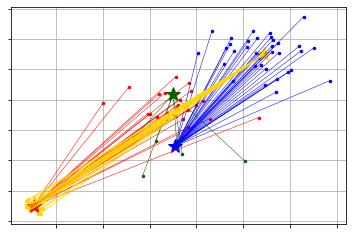

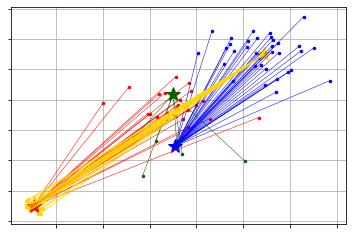

In [62]:
# Visualize obtained results
kmeans_visualizer.show_clusters(X, clusters, final_centers)